In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
from icecube_utils import (
    inference, 
    convert_to_3d,
    calculate_angular_error,
    load_pretrained_model
)
from train_large import config

graphnet: INFO     2023-03-19 12:04:41 - get_logger - Writing log to logs/graphnet_20230319-120441.log
graphnet: WARNING  2023-03-19 12:04:45 - warn_once - `icecube` not available. Some functionality may be missing.


In [3]:
size_multiplier = 1
model_name = 'angles_euc_aug'
state_dict_path = f'weights/{model_name}/state_dict_final.pth'

atan2 = False
zenith_uniform_to_zenith = None
# atan2 = True
# with open('data/fold_0.db.ecdf.pickle', 'rb') as f:
#     zenith_uniform_to_zenith = pickle.load(f)[1]

In [17]:
# %%capture --no-stdout 
# config['train_transforms'] = []
# config['dynedge']['dynedge_layer_sizes'] = [
#     (x * size_multiplier, y * size_multiplier) 
#     for x, y in [(128, 256), (336, 256), (336, 256), (336, 256)]
# ]
# config['batch_size'] = 200
# config['truth'] = ['zenith', 'azimuth']
# config['target'] = 'angles_sincos_euclidean'
# config['path'] = '/workspace/icecube/data/batch_14.db'
# config['inference_database_path'] = '/workspace/icecube/data/batch_656.db'
# config['bias'] = True

# model = load_pretrained_model(
#     config=config, 
#     state_dict_path=state_dict_path,
#     return_train_dataloader=False,
# )

# df = inference(
#     model.cuda(), 
#     config
# )
# df.to_hdf(f'results/{model_name}_final.h5', key='df', mode='w')
# df

odict_keys(['_gnn._conv_layers.0.nn.0.weight', '_gnn._conv_layers.0.nn.0.bias', '_gnn._conv_layers.0.nn.2.weight', '_gnn._conv_layers.0.nn.2.bias', '_gnn._conv_layers.1.nn.0.weight', '_gnn._conv_layers.1.nn.0.bias', '_gnn._conv_layers.1.nn.2.weight', '_gnn._conv_layers.1.nn.2.bias', '_gnn._conv_layers.2.nn.0.weight', '_gnn._conv_layers.2.nn.0.bias', '_gnn._conv_layers.2.nn.2.weight', '_gnn._conv_layers.2.nn.2.bias', '_gnn._conv_layers.3.nn.0.weight', '_gnn._conv_layers.3.nn.0.bias', '_gnn._conv_layers.3.nn.2.weight', '_gnn._conv_layers.3.nn.2.bias', '_gnn._post_processing.0.weight', '_gnn._post_processing.0.bias', '_gnn._post_processing.2.weight', '_gnn._post_processing.2.bias', '_gnn._readout.0.weight', '_gnn._readout.0.bias', '_tasks.0._affine.weight', '_tasks.0._affine.bias', '_tasks.1._affine.weight', '_tasks.1._affine.bias'])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]
graphnet: INFO     2023-03-18 14:53:41 - inference - Writing results to training/train_model_without_configs/batch_14/dynedge_angles_sincos_euclidean_my_example


In [4]:
def xyz_to_angles(x, y, z):
    # norm = np.linalg.norm([x, y, z], ord=2)
    # x, y, z = x / norm, y / norm, z / norm

    azimuth = np.arctan2(y, x)
    azimuth[azimuth < 0] += 2 * np.pi
    
    zenith = np.arccos(z)

    return azimuth, zenith

In [7]:
df1 = pd.read_hdf('results/angles_euc_aug_final.h5', key='df')
df2 = pd.read_hdf('results/contd.h5', key='df')

df1 = calculate_angular_error(convert_to_3d(df1))
df2 = calculate_angular_error(convert_to_3d(df2))
df1['angular_error'].mean(), df2['angular_error'].mean()

(1.0290689989271442, 1.0402722614959063)

In [8]:
a, b = xyz_to_angles(df1['direction_x'], df1['direction_y'], df1['direction_z'])
df1['azimuth_pred'] = a
df1['zenith_pred'] = b

a, b = xyz_to_angles(df2['direction_x'], df2['direction_y'], df2['direction_z'])
df2['azimuth_pred'] = a 
df2['zenith_pred'] = b

In [9]:
df = df1.copy()

# df['direction_x'] = (df1['direction_x'] + df2['direction_x']) / 2
# df['direction_y'] = (df1['direction_y'] + df2['direction_y']) / 2
# df['direction_z'] = (df1['direction_z'] + df2['direction_z']) / 2

# df['zenith_pred'] = (df1['zenith_pred'] + df2['zenith_pred']) / 2
# df['azimuth_pred'] = df2['azimuth_pred']

df['zenith_pred'] = df2['zenith_pred']
df['azimuth_pred'] = df2['azimuth_pred']
df2_bad_mask = df2['direction_kappa'] < 1
df.loc[df2_bad_mask, 'zenith_pred'] = df1.loc[df2_bad_mask, 'zenith_pred']
df.loc[df2_bad_mask, 'azimuth_pred'] = df1.loc[df2_bad_mask, 'azimuth_pred']

# df['zenith_pred'] = df2['zenith_pred']
# df['azimuth_pred'] = df2['azimuth_pred']
# df2_bad_mask = df2['direction_kappa'] < 1
# df.loc[df2_bad_mask, 'zenith_pred'] = df1.loc[df2_bad_mask, 'zenith_pred']
# df.loc[df2_bad_mask, 'azimuth_pred'] = df1.loc[df2_bad_mask, 'azimuth_pred']
# df.loc[~df2_bad_mask, 'zenith_pred'] = (df1.loc[~df2_bad_mask, 'zenith_pred'] + df2.loc[~df2_bad_mask, 'zenith_pred']) / 2
# df.loc[~df2_bad_mask, 'azimuth_pred'] = (df1.loc[~df2_bad_mask, 'azimuth_pred'] + df2.loc[~df2_bad_mask, 'azimuth_pred']) / 2

# df['zenith_pred'] = df2['zenith_pred']
# df['azimuth_pred'] = df2['azimuth_pred']
# df2_bad_mask = df2['direction_kappa'] < 1
# df['zenith_pred'] = df1['zenith_pred']
# df.loc[df2_bad_mask, 'azimuth_pred'] = df1.loc[df2_bad_mask, 'azimuth_pred']

def angles_to_xyz(azimuth, zenith):
    x = np.cos(azimuth) * np.sin(zenith)
    y = np.sin(azimuth) * np.sin(zenith)
    z = np.cos(zenith)
    return x, y, z

df['direction_x'], df['direction_y'], df['direction_z'] = angles_to_xyz(df['azimuth_pred'], df['zenith_pred'])
df = calculate_angular_error(df)
df['angular_error'].mean()

1.022426873701867

In [11]:
df.to_hdf('results/angles_merged.h5', key='df')

In [7]:
def angles_diff(a, b):
    a_complex = np.exp(1j * a)
    b_complex = np.exp(1j * b)
    return np.angle(a_complex * np.conj(b_complex))

df['zenith_diff'] = angles_diff(df['zenith'], df['zenith_pred'])
df['azimuth_diff'] = angles_diff(df['azimuth'], df['azimuth_pred'])
df1['zenith_diff'] = angles_diff(df1['zenith'], df1['zenith_pred'])
df1['azimuth_diff'] = angles_diff(df1['azimuth'], df1['azimuth_pred'])
df2['zenith_diff'] = angles_diff(df2['zenith'], df2['zenith_pred'])
df2['azimuth_diff'] = angles_diff(df2['azimuth'], df2['azimuth_pred'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: xlabel='zenith', ylabel='zenith_diff'>

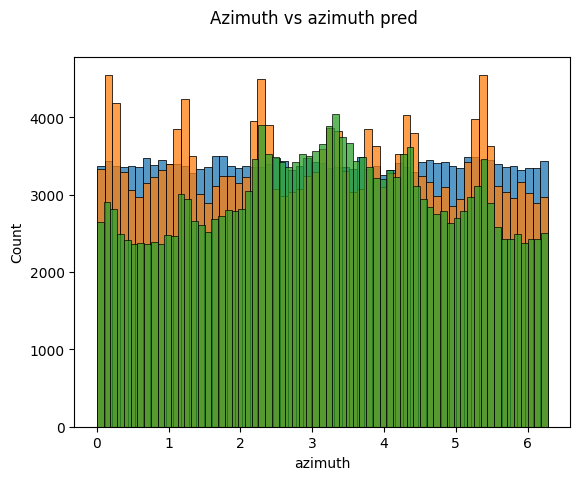

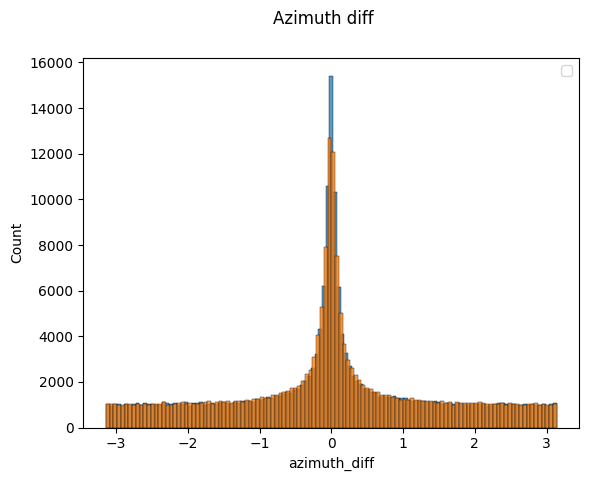

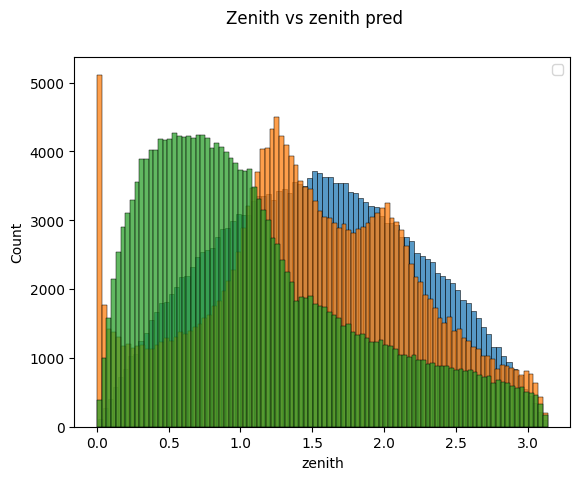

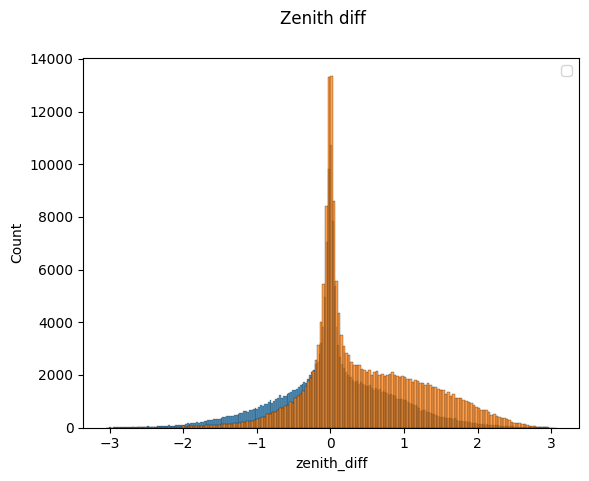

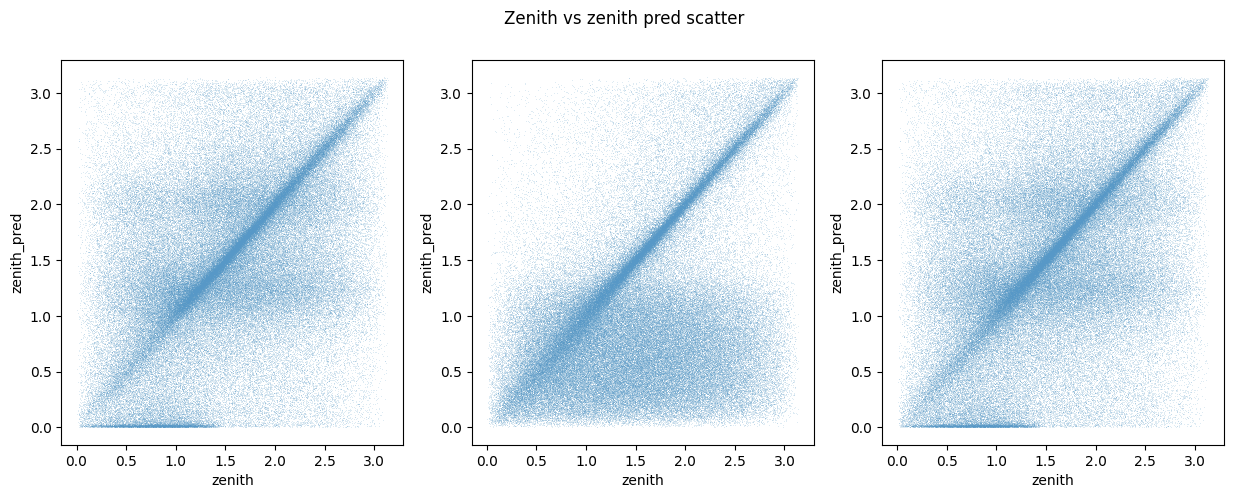

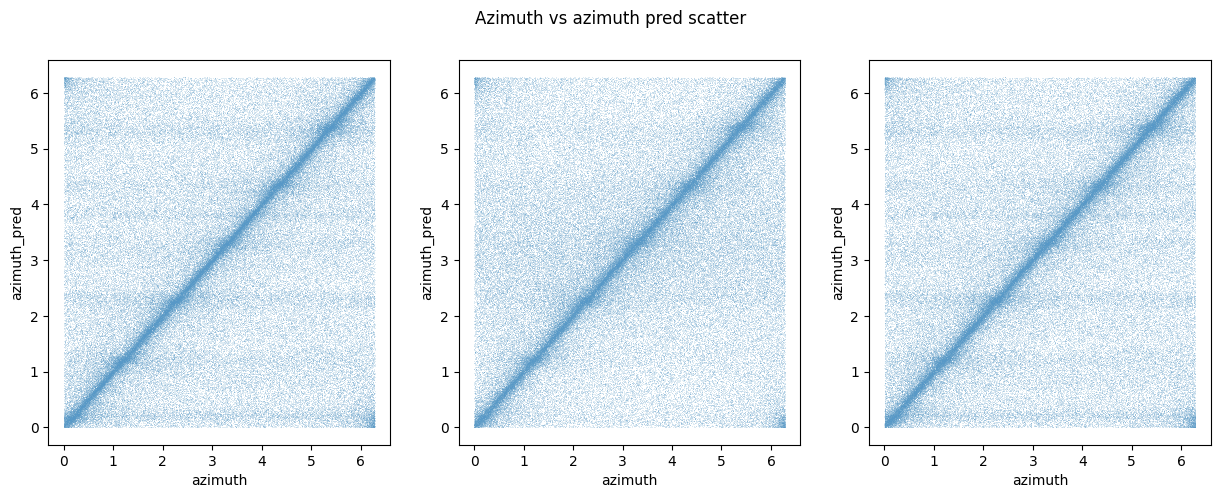

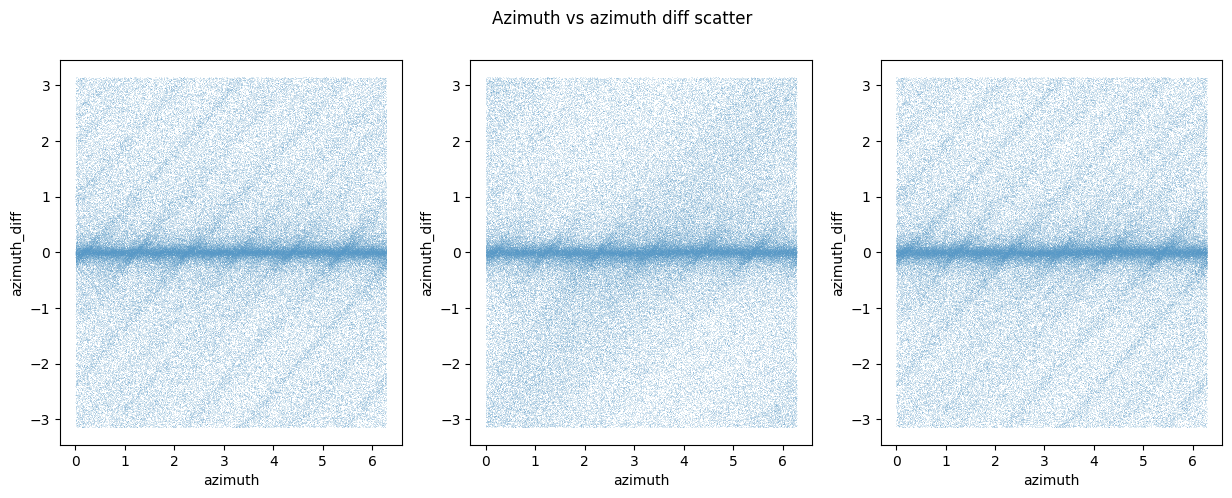

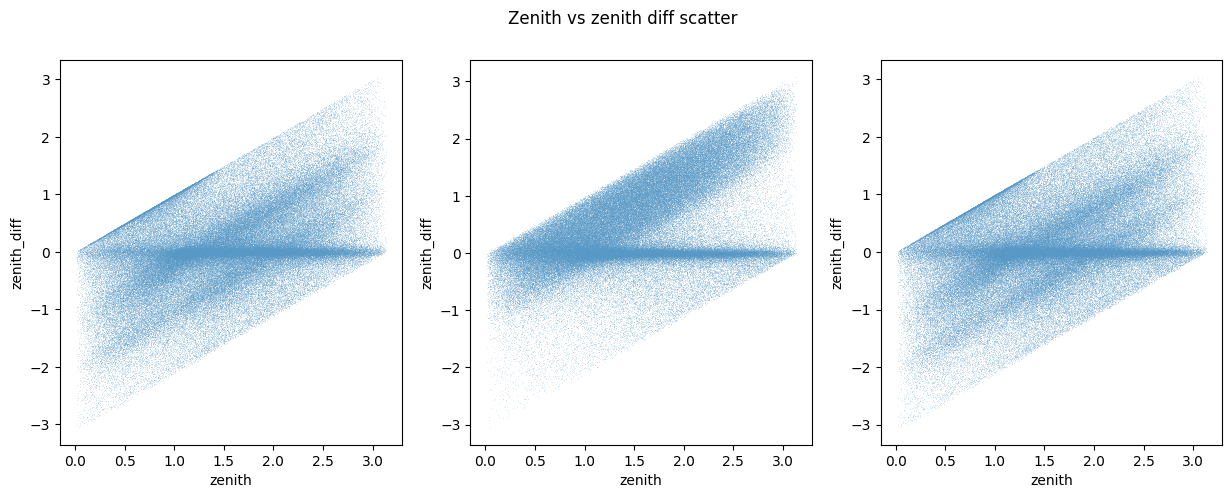

In [8]:
plt.figure()
plt.suptitle('Azimuth vs azimuth pred')
sns.histplot(data=df1, x='azimuth')
sns.histplot(data=df1, x='azimuth_pred')
sns.histplot(data=df2, x='azimuth_pred')

plt.figure()
plt.suptitle('Azimuth diff')
sns.histplot(data=df1, x='azimuth_diff')
sns.histplot(data=df2, x='azimuth_diff')
plt.legend()

plt.figure()
plt.suptitle('Zenith vs zenith pred')
sns.histplot(data=df1, x='zenith')
sns.histplot(data=df1, x='zenith_pred')
sns.histplot(data=df2, x='zenith_pred')
plt.legend()

plt.figure()
plt.suptitle('Zenith diff')
sns.histplot(data=df1, x='zenith_diff')
sns.histplot(data=df2, x='zenith_diff')
plt.legend()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Zenith vs zenith pred scatter')
sns.scatterplot(data=df1, x='zenith', y='zenith_pred', s=0.1, ax=axes[0])
sns.scatterplot(data=df2, x='zenith', y='zenith_pred', s=0.1, ax=axes[1])
sns.scatterplot(data=df, x='zenith', y='zenith_pred', s=0.1, ax=axes[2])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Azimuth vs azimuth pred scatter')
sns.scatterplot(data=df1, x='azimuth', y='azimuth_pred', s=0.1, ax=axes[0])
sns.scatterplot(data=df2, x='azimuth', y='azimuth_pred', s=0.1, ax=axes[1])
sns.scatterplot(data=df, x='azimuth', y='azimuth_pred', s=0.1, ax=axes[2])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Azimuth vs azimuth diff scatter')
sns.scatterplot(data=df1, x='azimuth', y='azimuth_diff', s=0.1, ax=axes[0])
sns.scatterplot(data=df2, x='azimuth', y='azimuth_diff', s=0.1, ax=axes[1])
sns.scatterplot(data=df, x='azimuth', y='azimuth_diff', s=0.1, ax=axes[2])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Zenith vs zenith diff scatter')
sns.scatterplot(data=df1, x='zenith', y='zenith_diff', s=0.1, ax=axes[0])
sns.scatterplot(data=df2, x='zenith', y='zenith_diff', s=0.1, ax=axes[1])
sns.scatterplot(data=df, x='zenith', y='zenith_diff', s=0.1, ax=axes[2])

In [9]:
df1['zenith_diff'].abs().mean(), df2['zenith_diff'].abs().mean(), df['zenith_diff'].abs().mean()

(0.5400453591677691, 0.6349318364785824, 0.543159178777722)

In [10]:
df1['azimuth_diff'].abs().mean(), df2['azimuth_diff'].abs().mean(), df['azimuth_diff'].abs().mean()

(1.059660241219042, 1.0678476701387551, 1.0557423282666465)

In [11]:
df_sensor_geometry = pd.read_csv('data/dataset/sensor_geometry.csv')

In [12]:
df_sensor_geometry

,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95
...,...,...,...,...
5155,5155,-10.97,6.72,-472.39
5156,5156,-10.97,6.72,-479.39
5157,5157,-10.97,6.72,-486.40
5158,5158,-10.97,6.72,-493.41


In [ ]:
import pandas as pd
import sqlite3

my_event_id = 0
my_database = '/workspace/icecube/data/batch_1.db'

def get_event(id, database_path):
    with sqlite3.connect(database_path) as conn:
        # extracts meta data for event
        meta_query = f'SELECT * FROM meta_table WHERE event_id = {id}'
        meta_data = pd.read_sql(meta_query,conn)
        
        # extracts pulses / detector response for event
        pulse_query = f'SELECT * FROM pulse_table WHERE event_id = {id}'
        pulse_data = pd.read_sql(pulse_query, conn)

        return meta_data, pulse_data
    

In [30]:
df.event_id.astype(int)

0         2131983614
1         2131983673
2         2131983677
3         2131983678
4         2131983690
             ...    
199995    2135241829
199996    2135241847
199997    2135241853
199998    2135241857
199999    2135241878
Name: event_id, Length: 200000, dtype: int64

In [32]:
import sqlite3
database_path = '/workspace/icecube/data/batch_656.db'
with sqlite3.connect(database_path) as conn:
    pulse_query = f'SELECT * FROM pulse_table WHERE event_id = {2131983614}'
    df_pulse = pd.read_sql(pulse_query, conn)
df_pulse

,event_id,sensor_id,time,charge,auxiliary,x,y,z
0,2131983614,1654,6223,0.525,1,248.15,-111.87,-80.67
1,2131983614,3147,6488,0.925,1,-234.95,140.44,40.50
2,2131983614,2482,6868,0.475,1,-403.14,3.49,127.35
3,2131983614,2136,8080,0.925,1,46.29,-34.88,-111.77
4,2131983614,2388,8162,0.775,1,544.07,55.89,-314.21
...,...,...,...,...,...,...,...,...
78,2131983614,3429,15401,1.325,1,382.35,238.90,345.36
79,2131983614,642,15979,1.125,1,158.94,-345.23,-215.04
80,2131983614,2999,16609,0.925,1,576.37,170.92,-510.18
81,2131983614,3079,16675,0.525,1,-358.44,120.56,174.67


In [34]:
df_pulse['time'].describe()

count       83.000000
mean     11138.481928
std       2141.369133
min       6223.000000
25%       9900.500000
50%      11159.000000
75%      11826.000000
max      16885.000000
Name: time, dtype: float64

In [33]:
df_pulse['charge'].describe()


count    83.000000
mean      1.135241
std       0.782225
min       0.125000
25%       0.725000
50%       0.975000
75%       1.225000
max       4.625000
Name: charge, dtype: float64

In [28]:
import plotly.graph_objects as go
from plotly import tools
import numpy as np
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

data = [
    go.Scatter3d(
        visible = True,
        x = df_sensor_geometry.x,
        y = df_sensor_geometry.y,
        z = df_sensor_geometry.z,
        mode='markers',
        marker=dict(
            size=1,
        )
    ),
    go.Scatter3d(
        visible = True,
        x = df_sensor_geometry.x,
        y = df_sensor_geometry.y,
        z = df_sensor_geometry.z,
        mode='markers',
        marker=dict(
            size=5,
            opacity=0.1,
        )
    )
]

fig = go.Figure(data=data)
fig.layout.scene.camera.projection.type = "orthographic"

iplot(fig, filename='Sine Wave Slider')

<Axes: xlabel='zenith', ylabel='zenith_diff'>

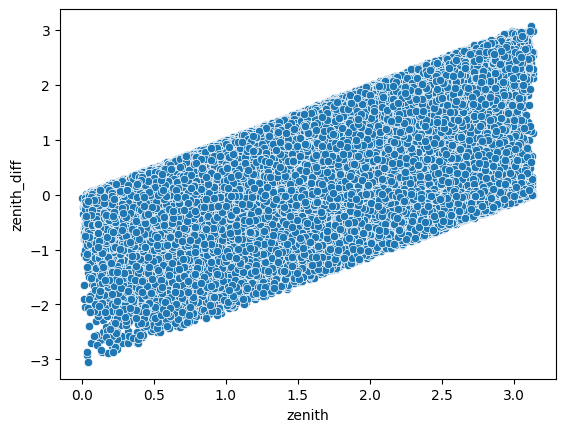

In [78]:
sns.scatterplot(data=df2, x='zenith', y='zenith_diff')

<Axes: xlabel='azimuth', ylabel='azimuth_diff'>

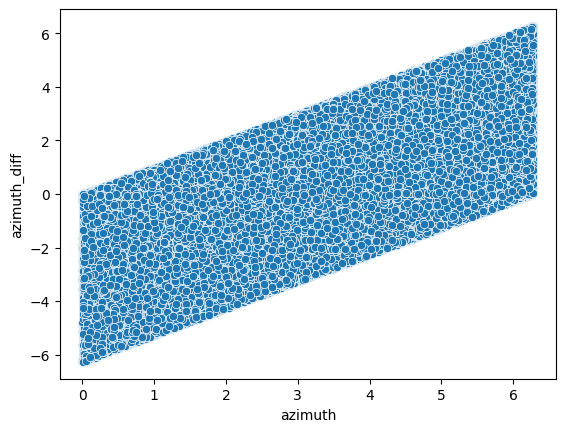

In [79]:
sns.scatterplot(data=df2, x='azimuth', y='azimuth_diff')

In [117]:
df1['angular_error'].mean(), df2['angular_error'].mean()

(1.0278379802594984, 1.0402722614959063)

In [27]:
df1['true_zenith_cos'] = np.cos(df1['zenith'])
df1['true_zenith_sin'] = np.sin(df1['zenith'])
df1['true_azimuth_cos'] = np.cos(df1['azimuth'])
df1['true_azimuth_sin'] = np.sin(df1['azimuth'])

<Axes: xlabel='true_azimuth_sin', ylabel='Count'>

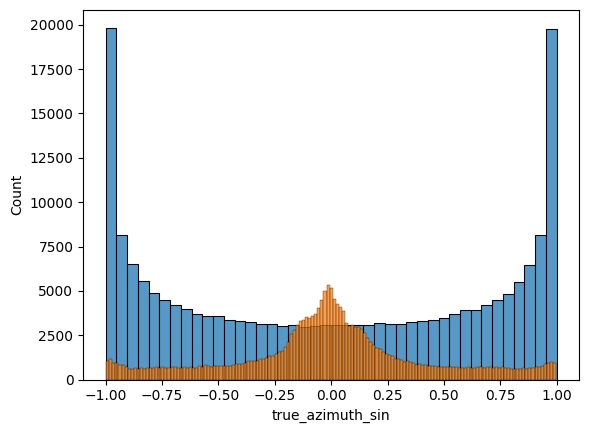

In [28]:
sns.histplot(data=df1, x='true_azimuth_sin')
sns.histplot(data=df1, x='azimuth_sin')

<Axes: xlabel='true_azimuth_cos', ylabel='Count'>

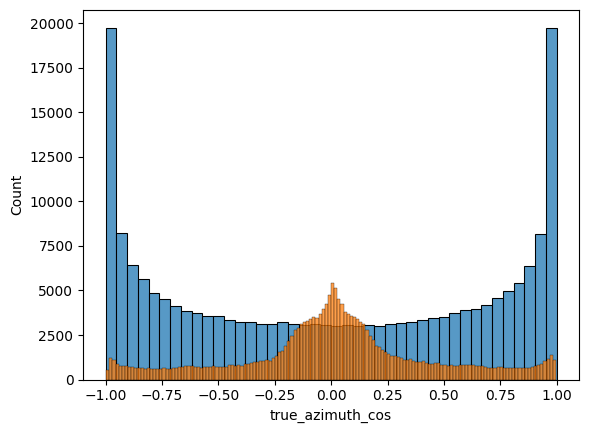

In [29]:
sns.histplot(data=df1, x='true_azimuth_cos')
sns.histplot(data=df1, x='azimuth_cos')

<Axes: xlabel='true_zenith_sin', ylabel='Count'>

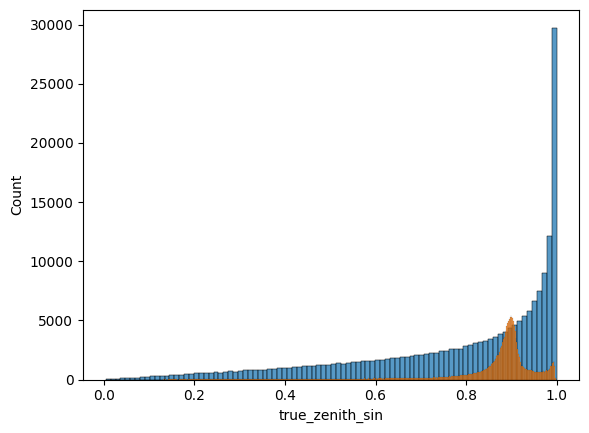

In [26]:
sns.histplot(data=df1, x='true_zenith_sin')
sns.histplot(data=df1, x='zenith_sin')

<Axes: xlabel='true_zenith_cos', ylabel='Count'>

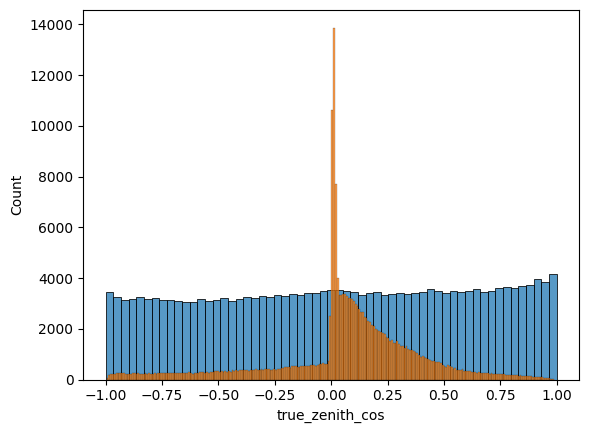

In [25]:
sns.histplot(data=df1, x='true_zenith_cos')
sns.histplot(data=df1, x='zenith_cos')

<Axes: xlabel='true_x', ylabel='Count'>

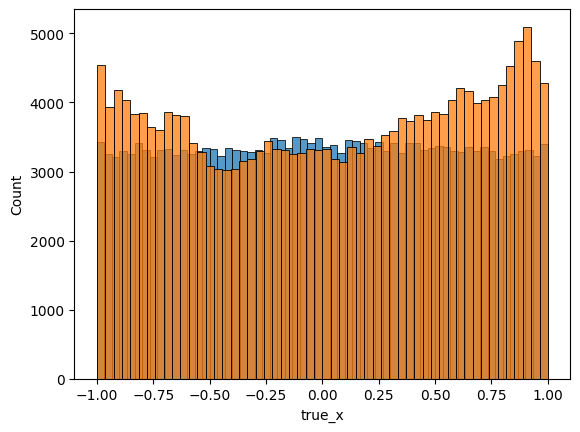

In [15]:
sns.histplot(data=df1, x='true_x')
sns.histplot(data=df1, x='direction_x')

<Axes: xlabel='true_y', ylabel='Count'>

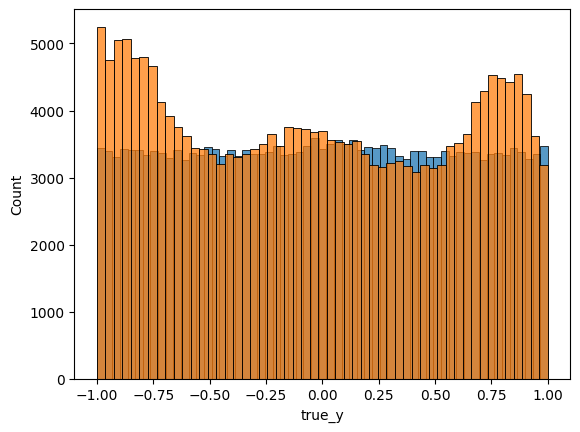

In [16]:
sns.histplot(data=df1, x='true_y')
sns.histplot(data=df1, x='direction_y')

<Axes: xlabel='true_z', ylabel='Count'>

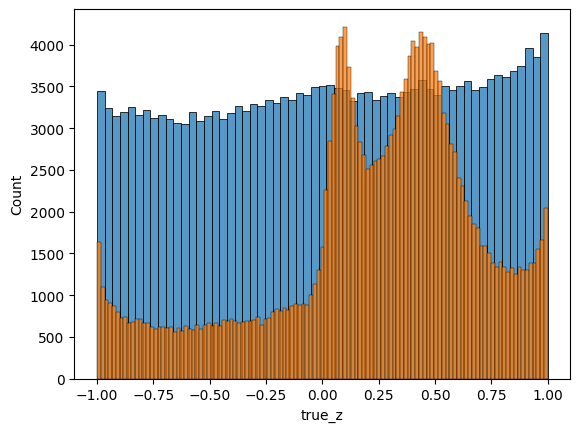

In [17]:
sns.histplot(data=df1, x='true_z')
sns.histplot(data=df1, x='direction_z')

ValueError: Could not interpret value `zenith_cos` for parameter `x`

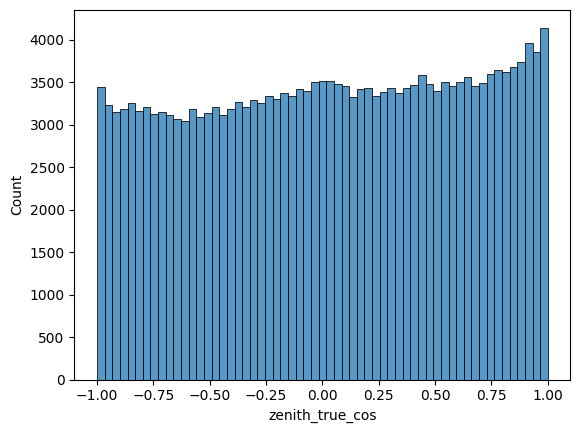

In [7]:
df['zenith_true_sin'] = np.sin(df['zenith'])
df['zenith_true_cos'] = np.cos(df['zenith'])
sns.histplot(data=df, x='zenith_true_cos')
sns.histplot(data=df, x='zenith_cos')

ValueError: Could not interpret value `azimuth_cos` for parameter `x`

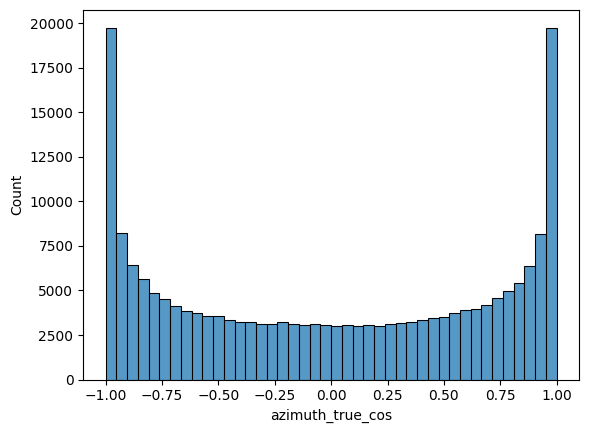

In [7]:
sns.histplot(data=df, x='azimuth_true_cos')
sns.histplot(data=df, x='azimuth_cos')

<Axes: xlabel='zenith_true_cos', ylabel='Count'>

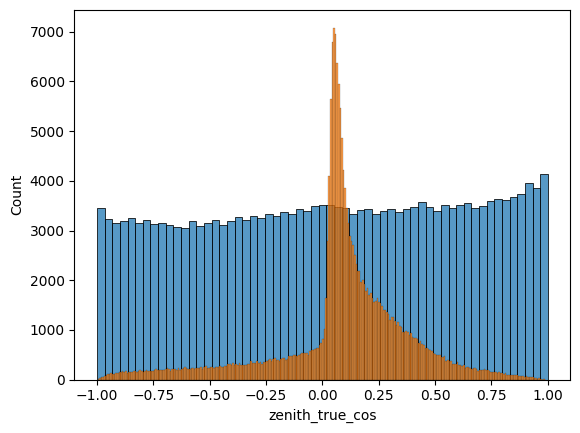

In [21]:
sns.histplot(data=df, x='zenith_true_cos')
sns.histplot(data=df, x='zenith_cos')

In [9]:
# df['zenith_pred'] = np.arctan2(df['zenith_sin'], df['zenith_cos'])
# df['zenith_pred'] = np.arccos(df['zenith_cos'])
# df['zenith_sin'] = (1 - df['zenith_cos'] ** 2) ** 0.5
# df['zenith_pred'] = np.arcsin(df['zenith_sin'])
df['zenith_sin'] = np.sin(df['zenith_pred'])
df['zenith_cos'] = np.cos(df['zenith_pred'])

df['azimuth_cos'] = df2['azimuth_cos']
df['azimuth_sin'] = df2['azimuth_sin']
df['direction_x'] = df['azimuth_cos'] * df['zenith_sin']
df['direction_y'] = df['azimuth_sin'] * df['zenith_sin']
df['direction_z'] = df['zenith_cos']

In [10]:
df[['zenith', 'zenith_pred']].sample(10)

,zenith,zenith_pred
28095,1.621109,1.816317
133168,2.449619,1.478536
72075,1.623235,1.722474
67454,2.241704,1.563911
181461,0.256034,1.464574
111695,1.380543,1.449717
174643,1.262183,1.348036
199668,1.092138,1.474673
128886,0.947410,1.340145
199484,0.568776,0.628248


<Axes: xlabel='zenith', ylabel='Count'>

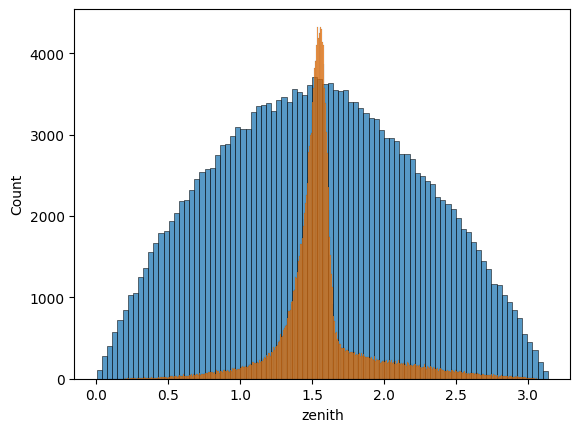

In [11]:
sns.histplot(data=df, x='zenith')
sns.histplot(data=df, x='zenith_pred')

In [31]:
df.zenith_diff.abs().mean()

0.46868544704206755

<Axes: xlabel='zenith', ylabel='zenith_diff'>

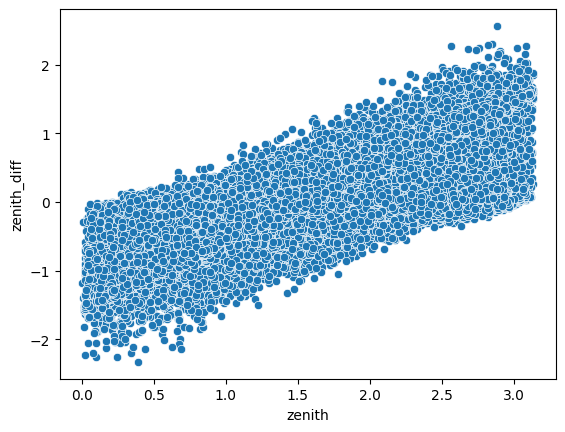

In [30]:
sns.scatterplot(data=df, x='zenith', y='zenith_diff')
# plt.xlim(0, np.pi)
# plt.ylim(0, np.pi)

In [17]:
df['zenith_diff'] = df['zenith'] - df['zenith_pred']

<Axes: xlabel='zenith', ylabel='zenith_diff'>

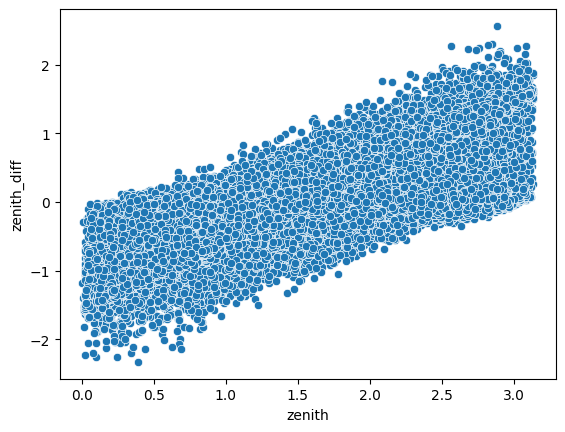

In [18]:
sns.scatterplot(data=df, x='zenith', y='zenith_diff')

In [13]:
df['true_x'] = np.cos(df['azimuth']) * np.sin(df['zenith'])
df['true_y'] = np.sin(df['azimuth']) * np.sin(df['zenith'])
df['true_z'] = np.cos(df['zenith'])
df['angular_error'] = np.arccos(df['true_x']*df['direction_x'] + df['true_y']*df['direction_y'] + df['true_z']*df['direction_z'])
df

/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


,zenith_pred,zenith_kappa,zenith,azimuth,event_id,zenith_true_sin,zenith_true_cos,zenith_sin,zenith_cos,azimuth_cos,azimuth_sin,direction_x,direction_y,direction_z,true_x,true_y,true_z,angular_error
0,2.407417,64.210037,2.433392,3.306649,2.131984e+09,0.650468,-0.759534,0.669976,-0.742383,-0.975538,-0.369990,-0.653586,-0.247884,-0.742383,-0.641628,-0.106877,-0.759534,NaN
1,1.585827,2.613179,1.125523,1.581094,2.131984e+09,0.902493,0.430705,0.999887,-0.015030,0.015834,-0.052399,0.015832,-0.052394,-0.015030,-0.009294,0.902445,0.430705,1.624725
2,2.767058,93.042213,2.725313,1.197849,2.131984e+09,0.404361,-0.914600,0.365840,-0.930678,0.398211,0.884462,0.145682,0.323571,-0.930678,0.147334,0.376564,-0.914600,0.104865
3,1.077680,4.191866,1.249805,1.478068,2.131984e+09,0.948923,0.315508,0.880862,0.473373,0.127148,0.093321,0.112000,0.082203,0.473373,0.087866,0.944846,0.315508,1.331661
4,1.564965,2.571446,2.138804,1.410056,2.131984e+09,0.842974,-0.537954,0.999983,0.005831,0.051468,-0.165469,0.051467,-0.165466,0.005831,0.134917,0.832108,-0.537954,1.705078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1.532586,2.650033,1.507717,3.996294,2.135242e+09,0.998011,0.063038,0.999270,0.038201,-0.154170,-0.090037,-0.154057,-0.089971,0.038201,-0.655139,-0.752874,0.063038,1.398877
199996,1.891054,57.237663,1.904201,6.219577,2.135242e+09,0.944934,-0.327262,0.949154,-0.314812,0.959595,-0.306557,0.910804,-0.290970,-0.314812,0.943023,-0.060065,-0.327262,0.203272
199997,1.584403,2.641780,2.491168,0.358167,2.135242e+09,0.605525,-0.795826,0.999907,-0.013606,0.026639,-0.128879,0.026637,-0.128867,-0.013606,0.567099,0.212272,-0.795826,1.572217
199998,1.502780,2.384618,0.225974,0.747326,2.135242e+09,0.224055,0.974576,0.997688,0.067964,0.064926,0.112338,0.064776,0.112079,0.067964,0.164347,0.152286,0.974576,1.476708


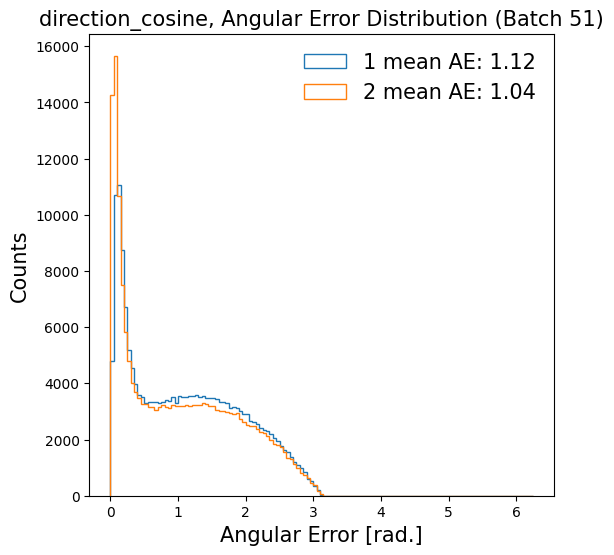

In [18]:
fig = plt.figure(figsize = (6,6))
plt.hist(df1['angular_error'], 
    bins = np.arange(0,np.pi*2, 0.05), 
    histtype = 'step', 
    label = f'1 mean AE: {np.round(df1["angular_error"].mean(),2)}'
)
plt.hist(df2['angular_error'], 
    bins = np.arange(0,np.pi*2, 0.05), 
    histtype = 'step', 
    label = f'2 mean AE: {np.round(df2["angular_error"].mean(),2)}'
)
plt.xlabel('Angular Error [rad.]', size = 15)
plt.ylabel('Counts', size = 15)
plt.title(f'{model_name}, Angular Error Distribution (Batch 51)', size = 15)
plt.legend(frameon=False, fontsize=15)